<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/GANy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project description**

Generative Adversial Network for Artificial ECG Generation


# **Install python packages**

In [2]:
!python --version
import keras
!pip3 install scipy keras
print(keras.__version__)


Python 3.6.9


Using TensorFlow backend.


2.3.1


# **Imports**

In [0]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path
from timeit import default_timer as timer

# numpy
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn

# Basics of Python data handling and visualization

import matplotlib.pyplot as plt
from matplotlib import pyplot
import scipy.io as sio
from timeit import default_timer as timer
import matplotlib as mpl

#keras
from keras.models import Sequential
from keras.layers import Conv1D, TimeDistributed, MaxPooling1D, Dense, Softmax, Flatten, LeakyReLU, Activation, BatchNormalization, Dropout, LSTM, Bidirectional, Reshape
from keras.activations import relu
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.initializers import RandomNormal

#preprocessing
import random
from sklearn import preprocessing
import scipy.stats
from scipy.signal import resample

# **Google drive**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # nazov pracovneho priecinku
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

          

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Paths**

In [0]:
#ANNOTATION - nazvy a anotacie/labely
ANNOTATION_PATH = WORKDIR_PATH / "annotFull.mat"
#MATDATA - signal database (.mat)
SINUS_PATH = WORKDIR_PATH / "SINUS"
AF_SV_VR_PATH = WORKDIR_PATH / "AF_SV_VR"
AB_AV_BB_PV_PATH = WORKDIR_PATH / "AB_AV_BB_PV"
OTHER_NOISY_PATH = WORKDIR_PATH / "OTHER_NOISY"

#**Data manipulation** (signals and labels)

In [60]:
matlab_data = sio.loadmat(file_name=ANNOTATION_PATH)
Ydata = matlab_data['YData']
print('Shape of Ydata ->' + str(Ydata.shape)+', 6884 = number of signals, 2 = signal_names,signal_labels')

signal_names = Ydata[:,0] 
signal_names = [str(signal_names).replace('[', '').replace("'", '').replace(']', '') for signal_names in signal_names.tolist()[:]]
#print('Number of signals ->' + str(len(signal_names)))
print('Names of signals ->' + str(signal_names))

signal_labels = Ydata[:,1]
#signal_labels = [str(signal_labels).replace('[', '').replace(']', '').replace(' ','') for signal_labels in signal_labels.tolist()[:]]
#print('Number of labels ->' + str(len(signal_labels)))
print('Signal labels ->' + str(signal_labels))

labels_names = matlab_data['annotLabel']
labels_names = [str(labels_names).replace('[', '').replace("'", '').replace(']', '').replace('', '') for labels_names in labels_names.tolist()[0]]
print('Names of labels ->' + str(labels_names))

# replace("'",'')


Shape of Ydata ->(6884, 2), 6884 = number of signals, 2 = signal_names,signal_labels
Names of signals ->['EB0000018570.mat', 'EB0000018571.mat', 'EB0000018572.mat', 'EB0000018573.mat', 'EB0000018574.mat', 'EB0000018575.mat', 'EB0000018576.mat', 'EB0000018577.mat', 'EB0000018578.mat', 'EB0000018579.mat', 'EB0000018580.mat', 'EB0000018581.mat', 'EB0000018582.mat', 'EB0000018583.mat', 'EB0000018584.mat', 'EB0000018585.mat', 'EB0000018586.mat', 'EB0000018587.mat', 'EB0000018588.mat', 'EB0000018589.mat', 'EB0000018590.mat', 'EB0000018591.mat', 'EB0000018592.mat', 'EB0000018593.mat', 'EB0000018594.mat', 'EB0000018595.mat', 'EB0000018596.mat', 'EB0000018597.mat', 'EB0000018598.mat', 'EB0000018599.mat', 'EB0000018600.mat', 'EB0000018601.mat', 'EB0000018602.mat', 'EB0000018603.mat', 'EB0000018604.mat', 'EB0000018605.mat', 'EB0000018606.mat', 'EB0000018607.mat', 'EB0000018608.mat', 'EB0000018609.mat', 'EB0000018610.mat', 'EB0000018611.mat', 'EB0000018612.mat', 'EB0000018613.mat', 'EB0000018614.m

# **Creating the database**

**Signaly1** = Signals with MULTIPLE labels (including specific type of label)

**Signaly2** = Signals with ONLY one type of label

In [61]:
AF1=[]; SI1=[];SV1=[];VR1=[];OT1=[];AV1=[];BB1=[];AB1=[];PV1=[];NO1=[]
AF2=[]; SI2=[];SV2=[];VR2=[];OT2=[];AV2=[];BB2=[];AB2=[];PV2=[];NO2=[]

def signal_type(i):
  switcher={
      0:AF2,1:SI2,2:SV2,3:VR2,4:OT2,5:AV2,6:BB2,7:AB2,8:PV2,9:NO2,
      10:AF1,11:SI1,12:SV1,13:VR1,14:OT1,15:AV1,16:BB1,17:AB1,18:PV1,19:NO1
    }
  return switcher.get(i,"Invalid number of label")


prefix=['AF2','SI2','SV2','VR2','OT2','AV2','BB2','AB2','PV2','NO1','AF1','SI1','SV1','VR1','OT1','AV1','BB1','AB1','PV1','NO1']

for counter in range(10,20):
  for item in Ydata.tolist():
    if list(item[1][0])[counter-10] == 1:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))


print('Signals with MANY types of labels including specific type of label:')
print('')
print('Number of AF1 signals ->' + str(len(signal_type(10))))
print('Number of SI1 signals ->' + str(len(signal_type(11))))
print('Number of SV1 signals ->' + str(len(signal_type(12))))
print('Number of VR1 signals ->' + str(len(signal_type(13))))
print('Number of OT1 signals ->' + str(len(signal_type(14))))
print('Number of AV1 signals ->' + str(len(signal_type(15))))
print('Number of BB1 signals ->' + str(len(signal_type(16))))
print('Number of AB1 signals ->' + str(len(signal_type(17))))
print('Number of PV1 signals ->' + str(len(signal_type(18))))
print('Number of NO1 signals ->' + str(len(signal_type(19))))
print('')

counter=0
for counter in range(10):
  for item in Ydata.tolist():
    if list(item[1][0])[counter] == 1 and sum(list(item[1][0])) < 2:
      signal_type(counter).append(str(prefix[counter])+str(item[0]).replace('[', '').replace("'", '').replace(']', ''))

print('Signals with ONLY one type of label:')
print('')
print('Number of AF2 signals ->' + str(len(signal_type(0))))
print('Number of SI2 signals ->' + str(len(signal_type(1))))
print('Number of SV2 signals ->' + str(len(signal_type(2))))
print('Number of VR2 signals ->' + str(len(signal_type(3))))
print('Number of OT2 signals ->' + str(len(signal_type(4))))
print('Number of AV2 signals ->' + str(len(signal_type(5))))
print('Number of BB2 signals ->' + str(len(signal_type(6))))
print('Number of AB2 signals ->' + str(len(signal_type(7))))
print('Number of PV2 signals ->' + str(len(signal_type(8))))
print('Number of NO2 signals ->' + str(len(signal_type(9))))
print('')

print('Database of signals was created.')

Signals with MANY types of labels including specific type of label:

Number of AF1 signals ->553
Number of SI1 signals ->5942
Number of SV1 signals ->194
Number of VR1 signals ->102
Number of OT1 signals ->88
Number of AV1 signals ->250
Number of BB1 signals ->434
Number of AB1 signals ->418
Number of PV1 signals ->413
Number of NO1 signals ->2183

Signals with ONLY one type of label:

Number of AF2 signals ->267
Number of SI2 signals ->3350
Number of SV2 signals ->89
Number of VR2 signals ->69
Number of OT2 signals ->5
Number of AV2 signals ->0
Number of BB2 signals ->0
Number of AB2 signals ->0
Number of PV2 signals ->0
Number of NO2 signals ->69

Database of signals was created.


##Lead II

Text(0, 0.5, 'Amplitúda [μV]')

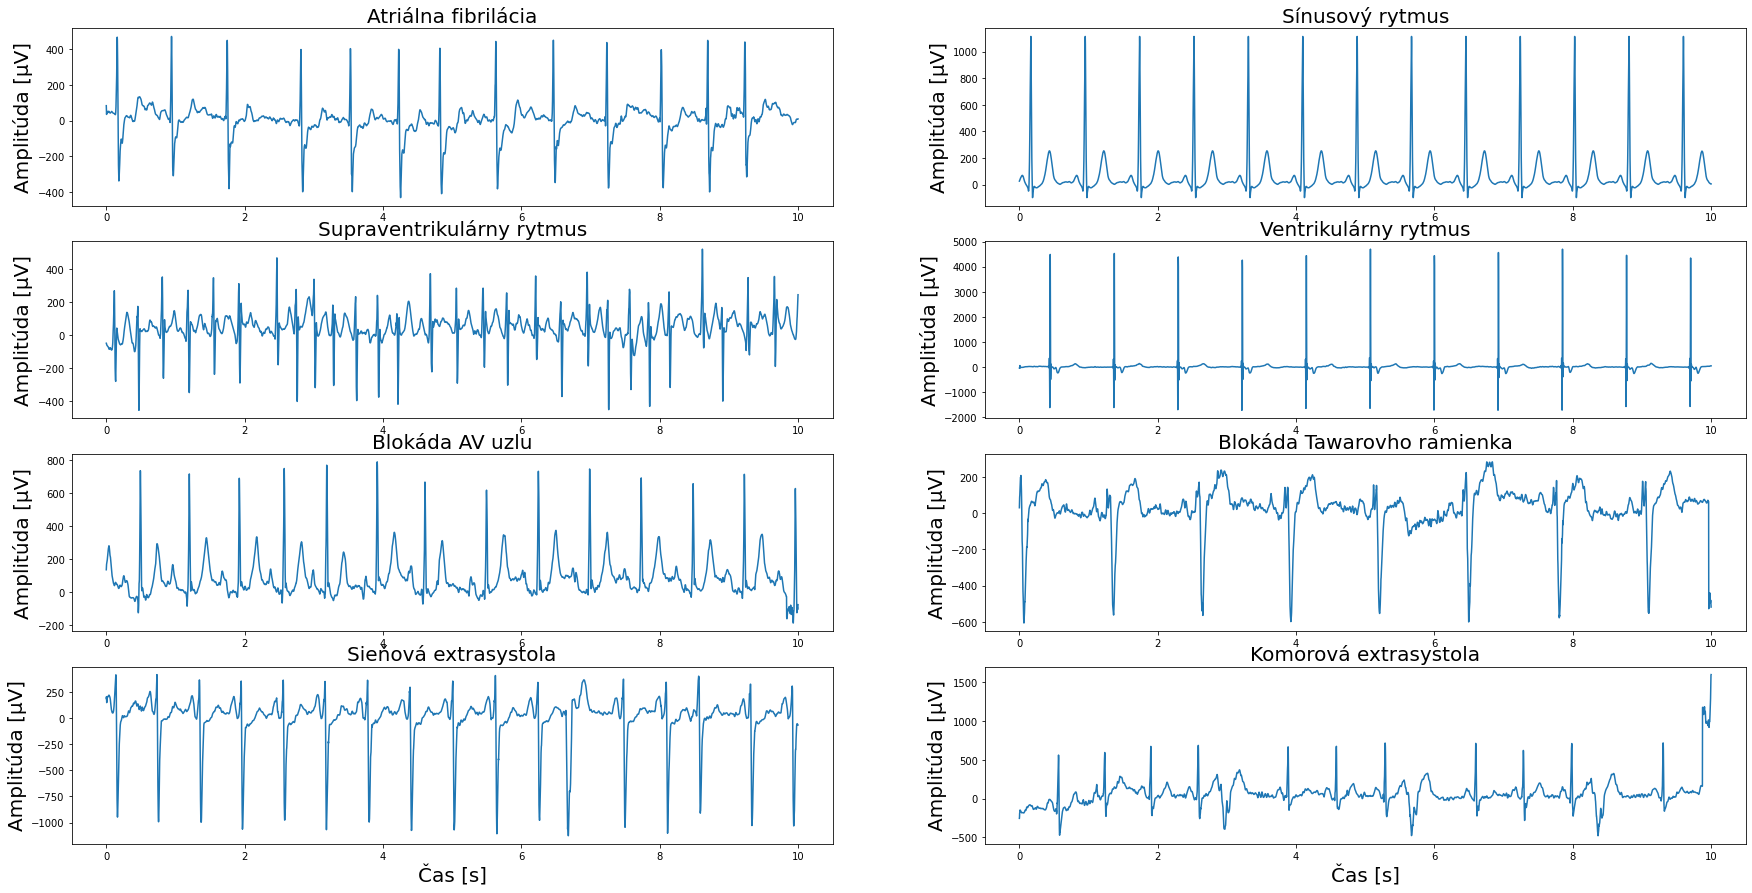

In [86]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,0]))
pyplot.title('Atriálna fibrilácia',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,0]))
pyplot.title('Sínusový rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,0]))
pyplot.title('Supraventrikulárny rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,0]))
pyplot.title('Ventrikulárny rytmus',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,0]))
pyplot.title('Blokáda AV uzlu',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,0]))
pyplot.title('Blokáda Tawarovho ramienka',fontsize=20)
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,0]))
pyplot.title('Sieňová extrasystola',fontsize=20)
pyplot.xlabel('Čas [s]',fontsize=20)
pyplot.ylabel('Amplitúda [μV]',fontsize=20)
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,0]))
pyplot.title('Komorová extrasystola',fontsize=20)
pyplot.xlabel('Čas [s]',fontsize=20)
pyplot.ylabel('Amplitúda [μV]',fontsize=20)


##AvR

Text(0, 0.5, 'Amplitude [μV]')

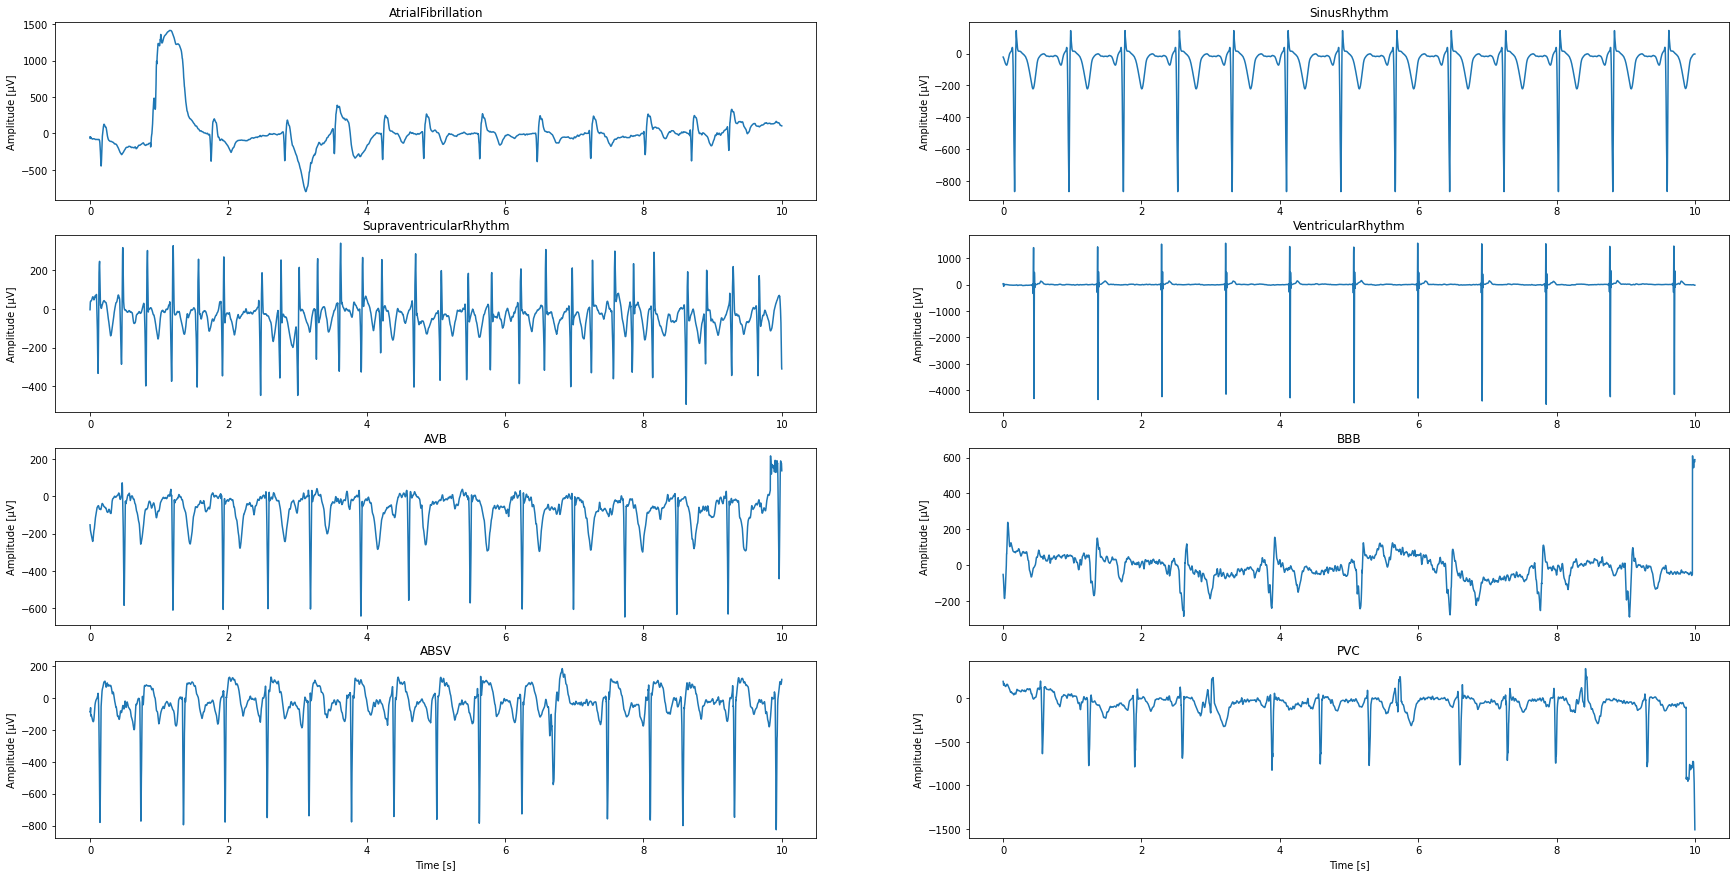

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,1]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,1]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,1]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,1]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,1]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,1]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,1]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,1]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')



##avL

numpy.ndarray

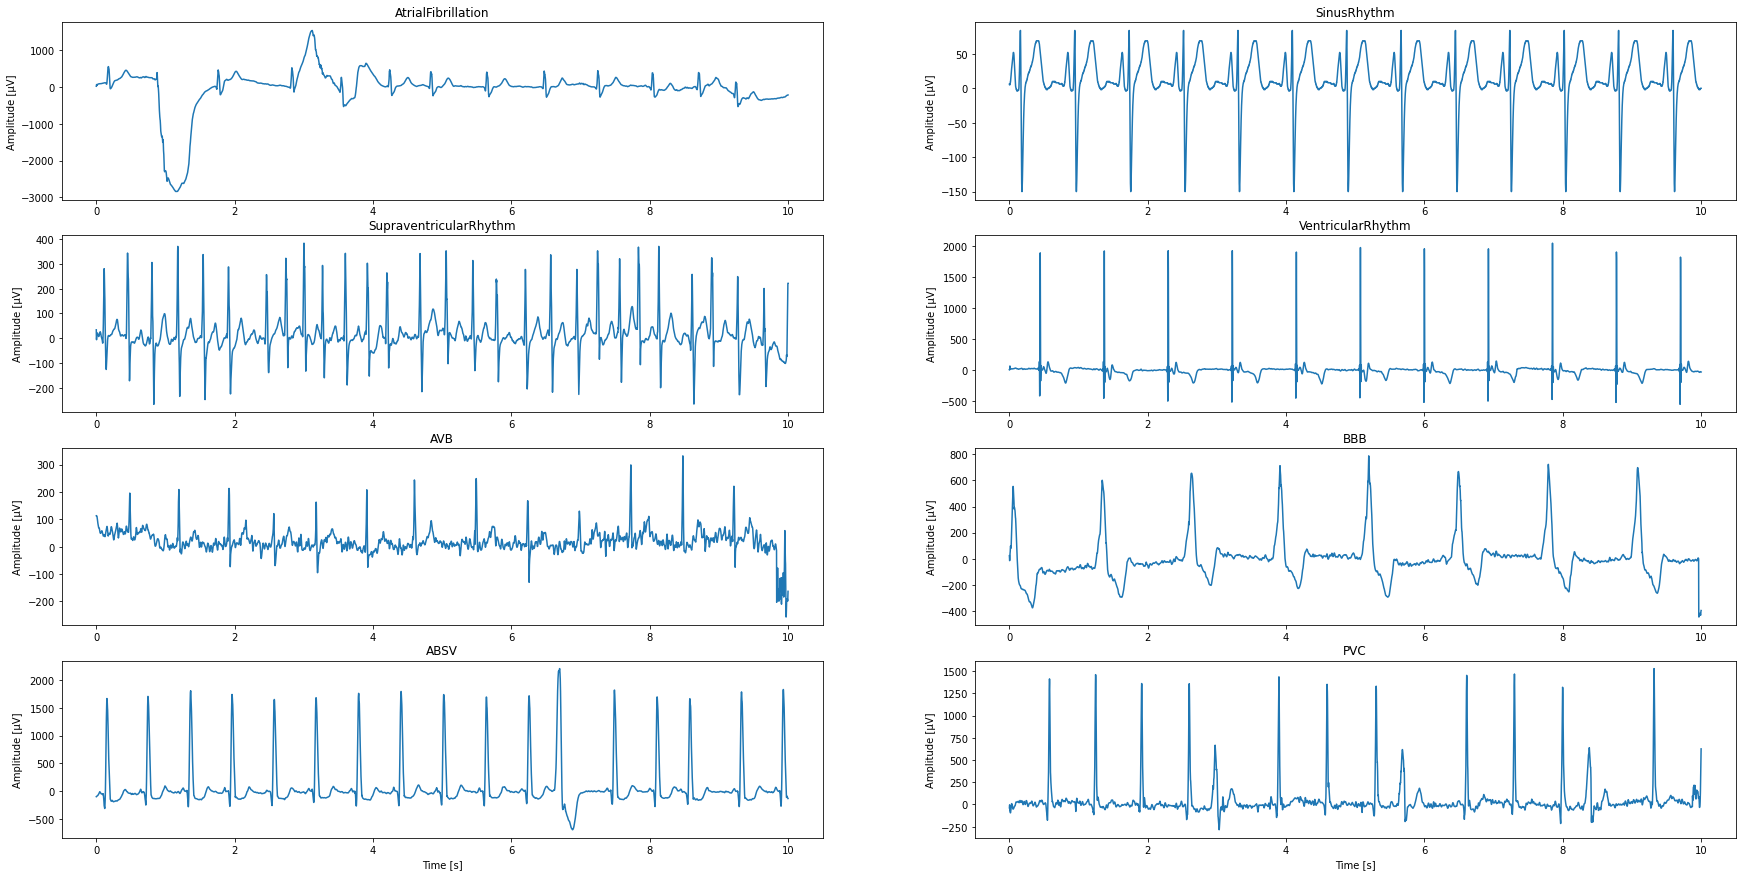

In [0]:
#AF1_PATH=AF_SV_VR_PATH / AF1[0]
#SV1_PATH=AF_SV_VR_PATH / SV1[0]
#VR1_PATH=AF_SV_VR_PATH / VR1[0]

AF2_PATH=AF_SV_VR_PATH / AF2[0]
SI2_PATH=SINUS_PATH / SI2[0]
SV2_PATH=AF_SV_VR_PATH / SV2[0]
VR2_PATH=AF_SV_VR_PATH / VR2[0]
AV1_PATH=AB_AV_BB_PV_PATH / AV1[0]
BB1_PATH=AB_AV_BB_PV_PATH / BB1[0]
AB1_PATH=AB_AV_BB_PV_PATH / AB1[0]
PV1_PATH=AB_AV_BB_PV_PATH / PV1[0]

#AF1_signal=sio.loadmat(AF1_PATH);
#SV1_signal=sio.loadmat(SV1_PATH)
#VR1_signal=sio.loadmat(VR1_PATH);

AF2_signal=sio.loadmat(AF2_PATH)
SI2_signal=sio.loadmat(SI2_PATH)
SV2_signal=sio.loadmat(SV2_PATH)
VR2_signal=sio.loadmat(VR2_PATH)
AV1_signal=sio.loadmat(AV1_PATH);
BB1_signal=sio.loadmat(BB1_PATH)
AB1_signal=sio.loadmat(AB1_PATH);
PV1_signal=sio.loadmat(PV1_PATH)

time_axis=np.linspace(0,10,5000)
plt.figure(figsize=(30,15))
plt.subplot(4, 2, 1)
AF2_signal=AF2_signal['data']
plt.plot(time_axis, (AF2_signal[:,2]))
pyplot.title(labels_names[0])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 2)
SI2_signal=SI2_signal['data']
plt.plot(time_axis, (SI2_signal[:,2]))
pyplot.title(labels_names[1])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 3)
SV2_signal=SV2_signal['data']
plt.plot(time_axis, (SV2_signal[:,2]))
pyplot.title(labels_names[2])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 4)
VR2_signal=VR2_signal['data']
plt.plot(time_axis, (VR2_signal[:,2]))
pyplot.title(labels_names[3])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 5)
AV1_signal=AV1_signal['data']
plt.plot(time_axis, (AV1_signal[:,2]))
pyplot.title(labels_names[5])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 6)
BB1_signal=BB1_signal['data']
plt.plot(time_axis, (BB1_signal[:,2]))
pyplot.title(labels_names[6])
#pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 7)
AB1_signal=AB1_signal['data']
plt.plot(time_axis, (AB1_signal[:,2]))
pyplot.title(labels_names[7])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')
plt.subplot(4, 2, 8)
PV1_signal=PV1_signal['data']
plt.plot(time_axis, (PV1_signal[:,2]))
pyplot.title(labels_names[8])
pyplot.xlabel('Time [s]')
pyplot.ylabel('Amplitude [μV]')

type(AF2_signal[:,0])


## Signal loading example

In [0]:
AF2_II=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_II.append(signal[:,0])

AF2_II=np.asarray(AF2_II)

print(np.shape(AF2_II))

AF2_avR=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avR.append(signal[:,1])

AF2_avR=np.asarray(AF2_avR)
print(np.shape(AF2_avR))

AF2_avL=[]
for i in range(len(AF2)):
  AF2_PATH=AF_SV_VR_PATH / AF2[i]
  signal=sio.loadmat(AF2_PATH)
  signal=signal['data']
  AF2_avL.append(signal[:,2])

AF2_avL=np.asarray(AF2_avL)

print(np.shape(AF2_avL))

labels=np.ones((len(AF2),1))

print(np.shape(labels))

(267, 5000)
(267, 5000)
(267, 5000)
(267, 1)


##Saving sinus signals

In [0]:
# load real samples of sinus rhythm
SI2_II=[]
for i in range(len(SI2)):
  SI2_PATH=SINUS_PATH / SI2[i]
  signal=sio.loadmat(SI2_PATH)
  signal=signal['data']
  SI2_II.append(signal[:,0])

SI2_II=np.asarray(SI2_II)
print(np.shape(SI2_II))
np.save(WORKDIR_PATH / "SI2_II_full",SI2_II)


(3350, 5000)


# **Electrocardiogram generation with a bidirectional LSTM-CNN generative adversarial network**
http://www.nature.com/articles/s41598-019-42516-z


### Signal loading arameters

In [0]:
# which signals to load

#subor= "SI2_II.npy"     # start signaly - 3120 samples from start (0-3120)
#subor="SI2_II_end.npy"  # end signaly - 3120 samples till end (1880-5000)
subor="SI2_II_full.npy"  # full signaly - all 5000 samples (0-5000)

## Preprocessing the input data
* Delete signals that does not fall into range [-1500, 2000]
* Clip them to range [1200, 1200] - easily normalized after
* Normalize inputs to the range [-1, 1] and use tanh in the generator output.

In [0]:
#odstranenie nevhodných signálov
clip_value_top=2000
clip_value_bottom=1500

#orezanie signálov
clip_value_top2=1200
clip_value_bottom2=1200

# vzorkovacia frekvenica (aku chceme)
fvz=360 #500 

In [8]:
SI2_II=np.load(WORKDIR_PATH / subor)
SI2_II=np.transpose(SI2_II)
SI2_II=SI2_II.astype('float32') 

print('Data type of SI2 ->          ' + str(SI2_II.dtype))
print('Type of SI2 ->               ' + str(type(SI2_II)))
print('Shape of SI2 ->              ' + str(np.shape(SI2_II)))

#prevzorkovanie signalu

resampled_signals_360=[]
for i in range(SI2_II.shape[1]):
	resampled_signals_360.append(scipy.signal.resample(SI2_II[:,i],3600))
resampled_signals_360=np.asarray(resampled_signals_360)
resampled_signals_360=np.transpose(resampled_signals_360)

print('Signal resampled from 500Hz to 360Hz ->              ' + str(np.shape(resampled_signals_360)))

#skratenie signalu

SI2_II=resampled_signals_360[479:3599,:]
print('Signal shortened from 3600 to 3120 samples ->              ' + str(np.shape(SI2_II)))

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]

print('Clip value top of SI2 ->         ' + str(clip_value_top) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom) + 'μV')

# orezanie signalov

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top:
      idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom):
      idx.append(i)

clipped_signals_idx=np.unique(idx)
print('Number of clipped signals -> ' + str(len(clipped_signals_idx)))

SI2_II=np.delete(SI2_II,clipped_signals_idx[:],1)
print('These signals were deleted.')

number_of_signals = SI2_II.shape[1]
length_of_signal = SI2_II.shape[0]
time_axis=np.linspace(0,length_of_signal/fvz,length_of_signal)

print('Clip value top of SI2 ->         ' + str(clip_value_top2) + 'μV')
print('Clip value bottom of SI2 ->      ' + str(clip_value_bottom2) + 'μV')

idx=[]
for i in range (number_of_signals):
  for j in range(length_of_signal):
    if SI2_II[j,i] > clip_value_top2:
      SI2_II[j,i]= clip_value_top2
      idx.append(i)
    elif SI2_II[j,i] < (-clip_value_bottom2):
      SI2_II[j,i]= -clip_value_bottom2
      idx.append(i)

print('Number of SI2 signals ->     ' + str(number_of_signals))
print('Length of SI2 signals ->     ' + str(length_of_signal))
print('Time axis :')
print(time_axis)
print('Time axis length is :' + str(len(time_axis)))
print('Max of SI_II_11 :' + str(np.amax(SI2_II)))
print('Min of SI_II_11 :' + str(np.amin(SI2_II)))

# transformacia dat

SI2_II_zscore=scipy.stats.zscore(SI2_II)
SI2_II_01=(SI2_II - np.amin(SI2_II)) / (np.amax(SI2_II) - np.amin(SI2_II))
SI2_II_11=(SI2_II)/clip_value_top2 #1200

print('Range of Z_score normalization ->     ' + '[' + str(np.amin(SI2_II_zscore)) + ',' + str(np.amax(SI2_II_zscore))+ ']' )
print('Range of 01 normalization ->          ' + '[' + str(np.amin(SI2_II_01)) + ',' + str(np.amax(SI2_II_01))+ ']' )
print('Range of 11 normalization ->          ' + '[' + str(np.amin(SI2_II_11)) + ',' + str(np.amax(SI2_II_11))+ ']' )  

# noisy

noisy_signals=[]
pure = np.linspace(-1, 1, SI2_II.shape[0])
noise = np.random.normal(0, 0.1, pure.shape)
for i in range(SI2_II.shape[1]):
	noisy_signals.append(SI2_II_11[:,i] + noise)
noisy_signals=np.asarray(noisy_signals)
noisy_signals=noisy_signals.reshape(SI2_II.shape[0],SI2_II.shape[1])

print('Range of noisy signals ->          ' + '[' + str(np.amin(noisy_signals)) + ',' + str(np.amax(noisy_signals))+ ']' )  
print('Shape of noisy_signals ->              ' + str(np.shape(noisy_signals)))

Data type of SI2 ->          float32
Type of SI2 ->               <class 'numpy.ndarray'>
Shape of SI2 ->              (5000, 3350)
Signal resampled from 500Hz to 360Hz ->              (3600, 3350)
Signal shortened from 3600 to 3120 samples ->              (3120, 3350)
Clip value top of SI2 ->         2000μV
Clip value bottom of SI2 ->      1500μV
Number of clipped signals -> 55
These signals were deleted.
Clip value top of SI2 ->         1200μV
Clip value bottom of SI2 ->      1200μV
Number of SI2 signals ->     3295
Length of SI2 signals ->     3120
Time axis :
[0.00000000e+00 2.77866838e-03 5.55733675e-03 ... 8.66110933e+00
 8.66388800e+00 8.66666667e+00]
Time axis length is :3120
Max of SI_II_11 :1200.0
Min of SI_II_11 :-1200.0
Range of Z_score normalization ->     [-8.92911,10.876356]
Range of 01 normalization ->          [0.0,1.0]
Range of 11 normalization ->          [-1.0,1.0]
Range of noisy signals ->          [-1.3258953356369565,1.3328492312340854]
Shape of noisy_signals -> 

## Discriminator

* The sequence comprising ECG data points can be regarded as a time series sequence (a normal image requires both a vertical convolution and a horizontal convolution) rather than an image, so only one-dimensional **(1-D) convolution** need to be involved.

* We assume that an input sequence x1, x2, … xT comprises T points, where each is represented by a d-dimensional vector.
 * teda 3120 bodov, kazdy z nich je reprezentoavany jednym bodom v 5D (laten_dim) 
 * input_shape=(None,3120,5) v generatore (None,3120,1) v diskriminatore

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 601, 10)           1210      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 601, 10)           0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 186, 10)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 51, 5)             1805      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 51, 5)             0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 10, 5)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 50)              

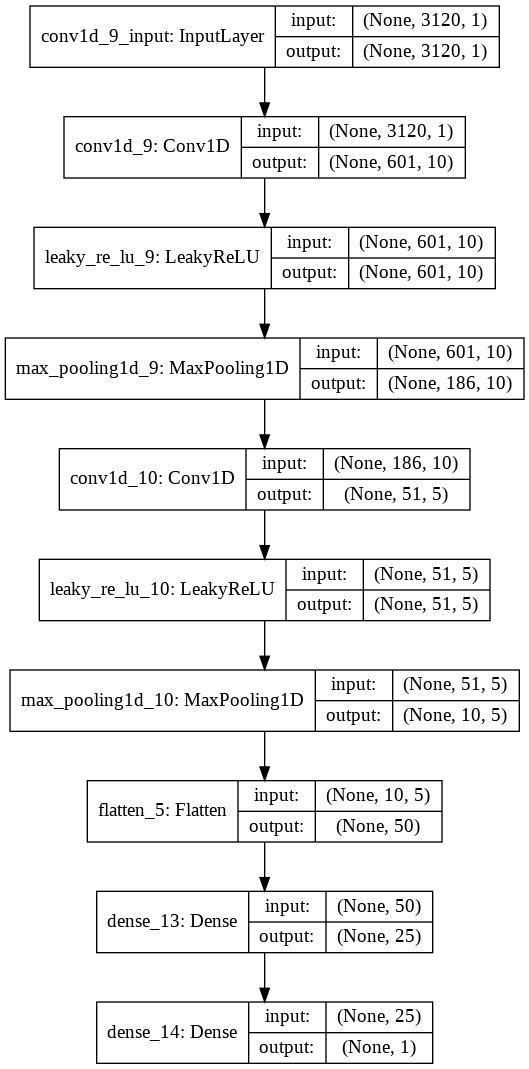

In [35]:
def define_discriminator(input_shape=(3120,1)):
  model = Sequential()
  model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid',kernel_initializer='he_normal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling1D(pool_size=46, strides=3, padding='valid', data_format='channels_last'))
  model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(MaxPooling1D(pool_size=24, strides=3, padding='valid', data_format='channels_last'))
  model.add(Flatten())
  model.add(Dense(25))
  #model.add(Dense(1))
  model.add(Dense(1,activation='sigmoid'))
  # optimalizacny algoritmus
  #adam_D = Adam(lr=0.0002, beta_1=0.5)
  #sgd_D = SGD(lr=0.001) 
  sgd_D = SGD(lr=0.0001) 
  #sgd_D = SGD(lr=0.00001)
  model.compile(loss='binary_crossentropy', optimizer=sgd_D, metrics=['accuracy'])
  return model

# zostavenie diskriminátoru
discriminator_model = define_discriminator()


# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

# model.add(Conv1D(input_shape=(3120,1),filters=10, kernel_size=120, strides=5, padding='valid', data_format='channels_last', dilation_rate=1, 
#                  activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', kernel_regularizer=None, 
#                  bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))
#model.add(BatchNormalization())

# model.add(Conv1D(filters=5, kernel_size=36, strides=3, padding='valid', data_format='channels_last', dilation_rate=1, 
#                  activation=None, use_bias=True, kernel_initializer='he_normal', bias_initializer='zeros', 
#                  kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None))

#NOTES:

# BCEWithLogitsLoss() and Sigmoid() doesn't work together, because BCEWithLogitsLoss() includes the Sigmoid activation. 
# So you can use BCEWithLogitsLoss() without Sigmoid() or you can use Sigmoid() and BCELoss()

# OPTIMALIZATION OPTIONS:

# 0 inicializacia
# 1 Use label smoothing in the discriminator, with small random noise.  
# 2 Add random noise to the labels in the discriminator.
# 3 Add noise to inputs to the discriminator and decay the noise over time.
# 4 Optimalizer / paper= SGD a mini-batch o dlzke 100 / adam je v GANoch standart
#   sgd = SGD(lr=0.00001)
#   adam = Adam(lr=0.0002, beta_1=0.5)
# 5 Remove Fully-Connected Layers
# 6 Use ReLU, Leaky ReLU, and Tanh
# 7 Kernel size, filters, strides

## Generator

*  series of noise data points that follow a Gaussian distribution are fed into the generator as a fixed length sequence. We assume that each noise point can be represented as a d-dimensional **?one-hot vector?** and the length of the sequence is T. Thus, the size of the input matrix is **T × d.** 

* To prevent slow gradient descent due to parameter inflation in the generator, we add a dropout layer and set the probability to 0.5. 

* The generator produces data based on the noise data sampled from a Gaussian distribution, which is **fitted to the real data distribution as accurately as possible.**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, activation="tanh", kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 3120, 100)         84800     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 3120, 100)         160800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 3120, 100)         0         
_________________________________________________________________
dense_12 (Dense)             (None, 3120, 1)           101       
Total params: 245,701
Trainable params: 245,701
Non-trainable params: 0
_________________________________________________________________


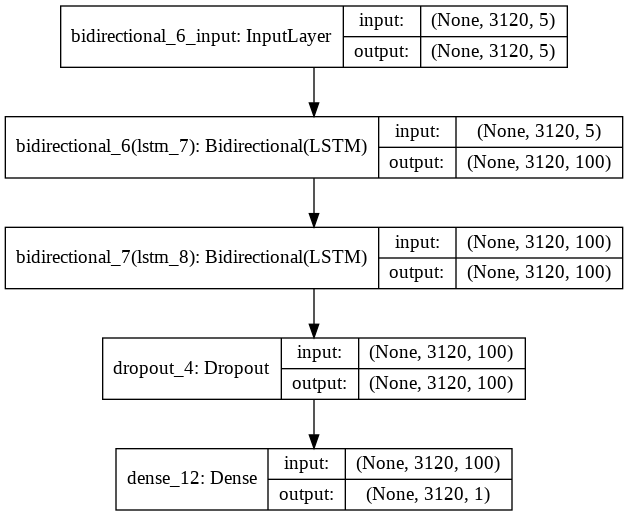

In [34]:
def define_generator(latent_dim):
  model = Sequential()
  model.add(Bidirectional(LSTM(100, return_sequences=True,init='glorot_normal',activation='tanh'), input_shape=(3120,latent_dim), merge_mode='sum'))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Bidirectional(LSTM(100, return_sequences=True,activation='tanh'),merge_mode='sum'))
  #model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.5, noise_shape=None, seed=None))
  model.add(Dense(1))
  #model.add(Dense(1, activation='tanh'))
  return model

# size of the latent space
latent_dim =5
# define the generator model
generator_model = define_generator(latent_dim)
# summarize the model
generator_model.summary()
# plot the model
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

# model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
# recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
# bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
# recurrent_dropout=0.0, implementation=2, return_sequences=True, 
# return_state=False, go_backwards=False, stateful=False, unroll=False),input_shape=(3120,latent_dim), merge_mode='sum'))
# return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

#model.add(Bidirectional(LSTM(100, activation='tanh', recurrent_activation='tanh', use_bias=True, kernel_initializer='random_normal', 
#recurrent_initializer='zeros', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, 
#bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, 
#recurrent_dropout=0.0, implementation=2, return_sequences=True, 
#return_state=False, go_backwards=False, stateful=False, unroll=False),merge_mode='sum'))

#latent space method 2

#model.add(Dense(3120*latent_dim, input_dim=latent_dim))
#model.add(LeakyReLU(alpha=0.2))
#model.add(Reshape((3120, latent_dim)))
#model.add(Bidirectional(LSTM(100, return_sequences=True,input_shape=(3120,latent_dim)), merge_mode='sum')) # input_shape=(batch_size,3120,latent_dim)

# NOTES:

# 1 Return sequences - TRUE
# 2 Use dropout of 50 percent during train and generation. - ALREADY USING
# 3 Normalize inputs to the range [-1, 1] and use tanh in the generator output. - DONE
# 4 LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
#   It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. ” alebo [-1,1] ak mam tanh

# OPTIMALIZATION OPTIONS:

# 1 Use Leaky ReLU in the generator and discriminator.
# 2 The best practice for DCAGAN models reported in the paper is to initialize all weights using 
#   a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.

## Possible tuning


### https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

### TIPS AND TRICKS:

*   Add random noise to the labels in the discriminator.
*   Add noise to inputs to the discriminator and decay the noise over time.

### ALREADY TRIED:

*   Use label smoothing in the discriminator, with small random noise.**DONE**
*   Use labels if you have them.**DONE**
*   Use dropout of 50 percent during train and generation. **DONE**
*   Normalize inputs to the range [-1, 1] and use tanh in the generator output. - **DONE**
*   Flip the labels and loss function when training the generator. - **DONE**
*   Sample Gaussian random numbers as input to the generator. - **DONE**
*   Use Leaky ReLU in the generator and discriminator. **DONE**
*   Use Average pooling and stride for downsampling; use ConvTranspose2D and stride for upsampling. **MAX POOLING, CONV1D**



## Generating fake and real signals



Mean of SI2_II_11_mean :
0.06107788
Std of SI2_II_11_mean :
0.12267831
Latent space points shape:
(5, 3120, 5)
Latent space 5 dimensions, 3120 samples : 
[[[ 1.35158870e-01  2.96919209e-02  8.53887798e-03 -1.68354133e-01
    1.46807050e-01]
  [ 4.02730670e-01  4.28065840e-03  1.54785404e-01 -1.09210699e-01
    1.54488855e-01]
  [ 9.20322168e-03  2.04959602e-01  2.16268222e-01  7.63407040e-02
   -2.44871750e-01]
  ...
  [ 1.77163570e-01  8.62191760e-02  7.74883165e-02  1.48386143e-01
   -3.69810181e-02]
  [ 2.70934408e-01  1.59919013e-01  2.05540326e-01  2.24436545e-01
   -2.09394327e-01]
  [-3.03689830e-03  2.23605624e-02 -5.92232141e-02 -1.73888367e-02
    9.55188670e-03]]

 [[ 2.07425272e-02  9.12202706e-02 -4.53217934e-02  2.49096717e-01
   -1.17800519e-01]
  [ 2.00333521e-01  1.41422130e-01  3.88830256e-02  5.60290782e-02
    2.37249881e-01]
  [ 1.70576439e-01  1.62942349e-01  1.08275000e-02 -4.80807748e-02
   -3.91818078e-03]
  ...
  [ 1.63807549e-02  8.93707957e-02  1.95651563e-0

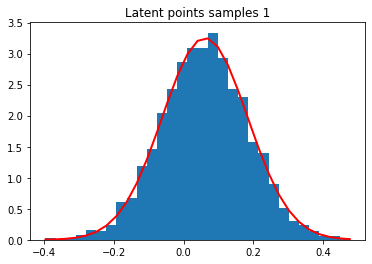

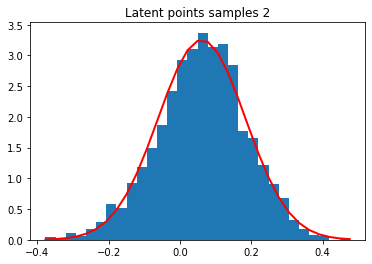

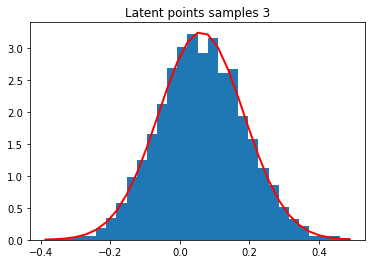

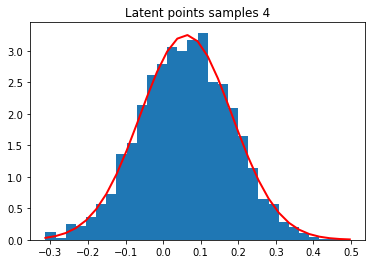

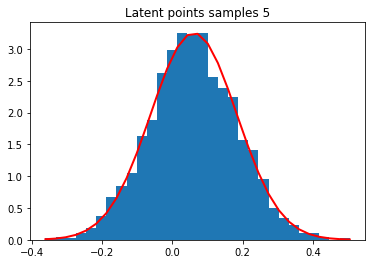

Fake data points shape:
(5, 3120, 1)
Fake data  points [0]:
[-0.00979727 -0.0088007  -0.008374   ...  0.02577128  0.0256231
  0.02246678]


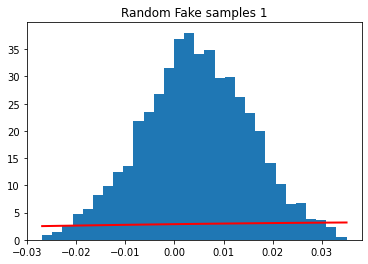

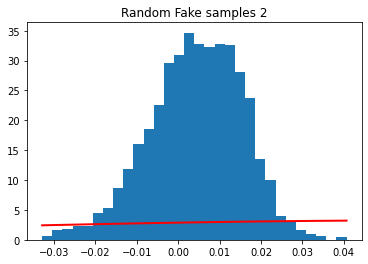

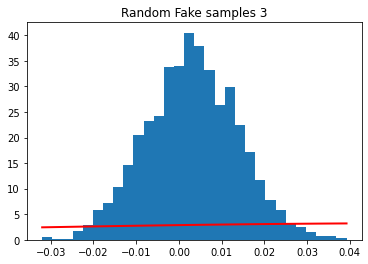

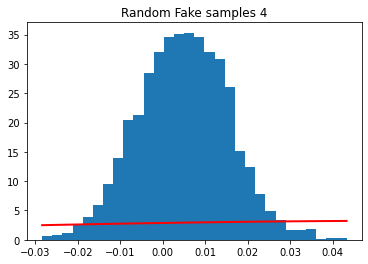

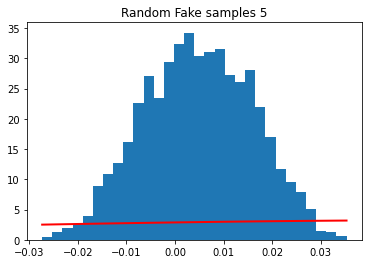

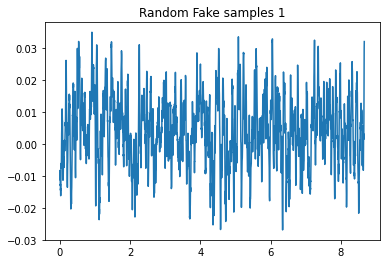

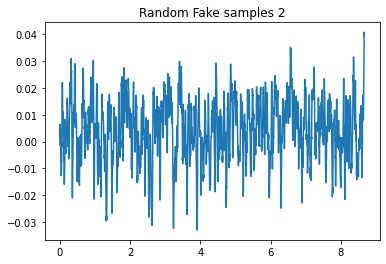

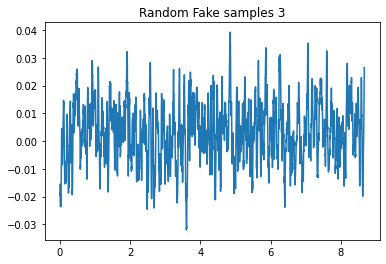

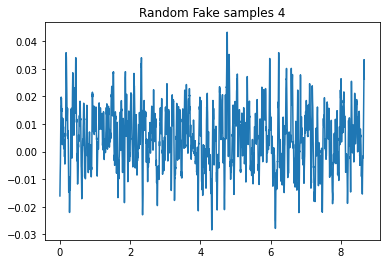

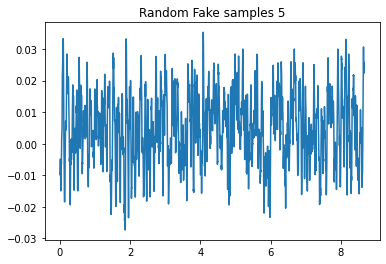

Real data points shape:
(5, 3120, 1)
Real data  points [0]:
[[0.14245942]
 [0.1428967 ]
 [0.14448935]
 ...
 [0.02914749]
 [0.02923002]
 [0.02902242]]
Length of Real data  points [0]:
3120


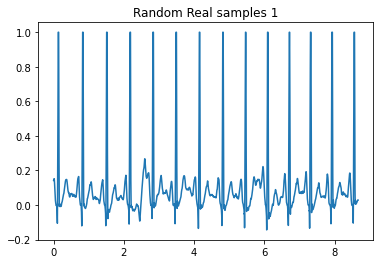

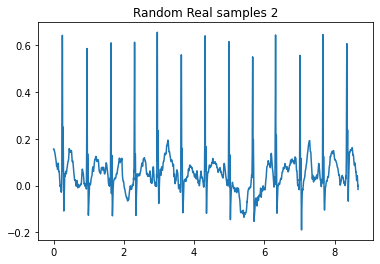

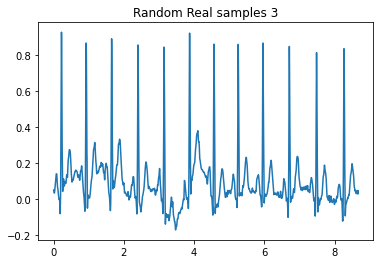

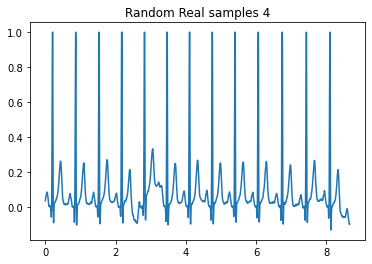

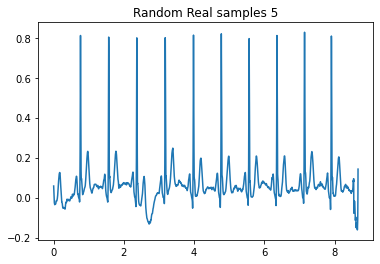

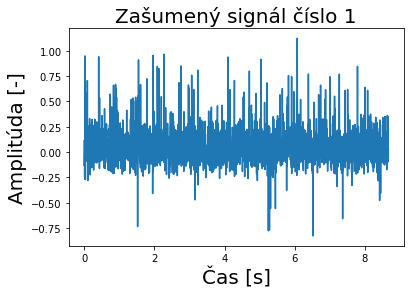

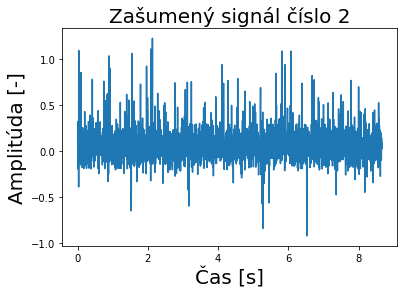

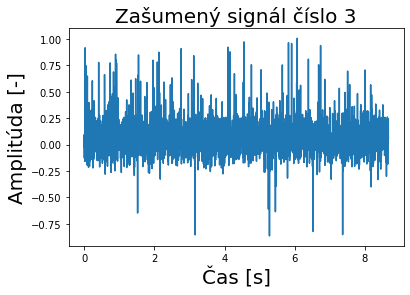

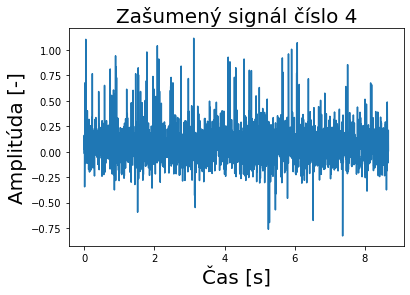

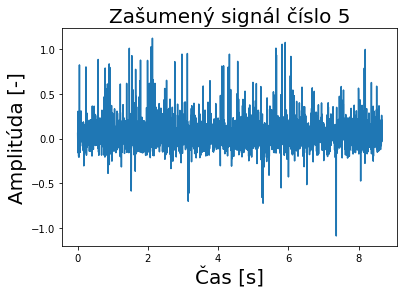

In [23]:
# generovanie latentnych bodov

def generate_latent_points(latent_dim,batch_size,mu,sigma):
  # generate points in the latent space
  latent_points = np.random.normal(mu,sigma, size=(3120 * latent_dim * batch_size))
  latent_points=latent_points.reshape(batch_size,length_of_signal,latent_dim) #batch x 3120 x 5
  return latent_points


# generovanie falosnych signalov

def generate_fake_samples(generator, latent_dim, batch_size,mu,sigma):
  # generovanie latentnych bodov
  X = generate_latent_points(latent_dim, batch_size,mu,sigma)
  x_input = generator_model.predict(X)
  # label smoothing - intervalove oznacenia skupin
  label=[]
  for i in range(batch_size):
    y = np.round(random.uniform(0, 0.1),2)
    label.append(y)
  label=np.asarray(label)
  y=label.reshape(batch_size,1)
  #y = np.zeros((batch_size,1))
  return x_input,y

# generovanie realnych signalov

def generate_real_samples(batch_size,signal):
  label=[]
  X=[]
  #nahodne cislo signalu
  for i in range (batch_size):
    cislo_signalu=random.randint(0, signal.shape[1]-1)
    X.append(signal[:,cislo_signalu])
  X=np.asarray(X)
  X=X.reshape(batch_size,length_of_signal,1)

  # label smoothing - intervalove oznacenia skupin
  for i in range(batch_size):
    y = np.round(random.uniform(0.9, 1),2)
    label.append(y)
  label=np.asarray(label)
  y=label.reshape(batch_size,1)
  #y = np.ones((batch_size,1))
  return X,y 

# statistiky signalu pre specificke rozlozenie

SI2_II_11_mean=np.mean(np.mean(SI2_II_11, axis=0))
SI2_II_11_std=np.std(SI2_II_11)
time_axis=np.linspace(0,length_of_signal/360,length_of_signal)

print('Mean of SI2_II_11_mean :')
print(SI2_II_11_mean)
print('Std of SI2_II_11_mean :')
print(SI2_II_11_std)  

latent_points=generate_latent_points(latent_dim=5,batch_size=5,mu=SI2_II_11_mean,sigma=SI2_II_11_std)
print('Latent space points shape:')
print(np.shape(latent_points))
print('Latent space 5 dimensions, 3120 samples : ')
print(latent_points)

#plot latent points

for i in range(5): 
  count, bins, ignored = plt.hist(latent_points[i][:,0], 30, density=True)
  plt.plot(bins, 1/(SI2_II_11_std * np.sqrt(2 * np.pi))*np.exp( - (bins - SI2_II_11_mean)**2 / (2 * SI2_II_11_std**2) ), linewidth=2, color='r')
  pyplot.title('Latent points samples'+ ' '+ str(i+1))
  plt.show()

# falosne signaly

fake_data,y = generate_fake_samples(generator_model, latent_dim=5,batch_size=5, mu=SI2_II_11_mean, sigma=SI2_II_11_std)

print('Fake data points shape:')
print(np.shape(fake_data))
print('Fake data  points [0]:')
print(fake_data[i][:,0])

# plot rozlozenia falosnych signalov

for i in range(5): 
  count, bins, ignored = plt.hist(fake_data[i][:,0], 30, density=True)
  plt.plot(bins, 1/(SI2_II_11_std * np.sqrt(2 * np.pi))*np.exp( - (bins - SI2_II_11_mean)**2 / (2 * SI2_II_11_std**2) ), linewidth=2, color='r')
  pyplot.title('Random Fake samples'+ ' '+ str(i+1))
  plt.show()

# plot falosnych signalov

for i in range(5): 
  # plot samples
  plt.plot(time_axis, fake_data[i][:,0])
  pyplot.title('Random Fake samples'+ ' '+ str(i+1)) 
  pyplot.show()

# realne signaly

real_data,y = generate_real_samples(5,SI2_II_11)

print('Real data points shape:')
print(np.shape(real_data))
print('Real data  points [0]:')
print(real_data[0])
print('Length of Real data  points [0]:')
print(len(real_data[0]))

# plot realnych signalov

for i in range(5): 
  plt.plot(time_axis, real_data[i])
  pyplot.title('Random Real samples'+ ' '+ str(i+1)) 
  pyplot.show()

# zasumene signaly

for i in range(5): 
  plt.plot(time_axis, noisy_signals[:,i])
  pyplot.title('Zašumený signál číslo'+ ' '+ str(i+1),fontsize=20) 
  pyplot.xlabel('Čas [s]',fontsize=20)
  pyplot.ylabel('Amplitúda [-]',fontsize=20) 
  pyplot.show()

### **As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble signal.**

## Testing the discriminator

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

Therefore, in GAN cases, you don't want D loss to go to zero because that would mean that D is doing a too good job (and most importantly, G a too bad one), ie it can easily discriminate between fake and real data (ie G's creations are not close enough to real data).

In [29]:
start = timer()

# vytvorenie trenovacej a testovacej databazy 80/20 
number_of_train_signals=int(np.round(number_of_signals*0.8))
SI2_II_11_train=SI2_II_11[:,0:number_of_train_signals]
SI2_II_11_test=SI2_II_11[:,number_of_train_signals:number_of_signals]

print('Shape of TRAIN SI2 signals->     ' + str(np.shape(SI2_II_11_train)))
print('Shape of TEST SI2 signals ->     ' + str(np.shape(SI2_II_11_test)))
print('Shape of NOISY SI2 signals ->     ' + str(np.shape(noisy_signals)))
	
# testovanie diskriminatora

def test_discriminator(model,train_signals,test_signals, n_iters, batch_size):

	half_batch = int(batch_size / 2)
 
	for i in range(n_iters):

		# realne signaly
		x_real_train, y_real_train = generate_real_samples(half_batch,train_signals)   #50 train real
		x_real_test, y_real_test = generate_real_samples(half_batch,test_signals)			 #50 test real

		# trening diskriminatora
		train_loss, train_acc = model.train_on_batch(x_real_train, y_real_train)
	
		# # falosne zasumene signaly
		# x_fake,_=generate_real_samples(half_batch,noisy_signals)	#50 noisy
		# _, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch, SI2_II_11_mean, SI2_II_11_std) #oznacenia chceme fake=0

		# falosne signaly z generatoru
		x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch, SI2_II_11_mean, SI2_II_11_std)		 #50 fake 

		# update discriminator on fake/noisy samples
		loss_fake, fake_acc = model.train_on_batch(x_fake, y_fake)
	
		print('>%d train_acc=%.0f%% fake_acc=%.0f%% 		train_loss=%f fake_loss=%f' % (i+1, train_acc*100, fake_acc*100, train_loss, loss_fake))
		train_acc_graph.append(train_acc)
		train_loss_graph.append(train_loss)
		fake_acc_graph.append(fake_acc)
		loss_fake_graph.append(loss_fake)


train_acc_graph=[]
fake_acc_graph=[]
train_loss_graph=[]
loss_fake_graph=[]

# vytvorenie diskriminatoru
discriminator_model = define_discriminator(input_shape=(3120,1))
# testovanie diskriminatoru
test_discriminator(discriminator_model,SI2_II_11_train,SI2_II_11_test, 200, 200)

end = timer()
print('Time of training:') 
print(end - start) #1911.7685786840002=31 MINUT, #1215.347090326 200 iteracii

np.save(WORKDIR_PATH / "train_acc_graphA",train_acc_graph)
np.save(WORKDIR_PATH / "fake_acc_graphA",fake_acc_graph)
np.save(WORKDIR_PATH / "train_loss_graphA",train_loss_graph)
np.save(WORKDIR_PATH / "loss_fake_graphA",loss_fake_graph)


Shape of TRAIN SI2 signals->     (3120, 2636)
Shape of TEST SI2 signals ->     (3120, 659)
Shape of NOISY SI2 signals ->     (3120, 3295)
>1 train_acc=4% fake_acc=0% 		train_loss=0.456042 fake_loss=0.732760
>2 train_acc=10% fake_acc=0% 		train_loss=0.432398 fake_loss=0.732571
>3 train_acc=4% fake_acc=0% 		train_loss=0.442590 fake_loss=0.733799
>4 train_acc=3% fake_acc=0% 		train_loss=0.425890 fake_loss=0.733845
>5 train_acc=5% fake_acc=0% 		train_loss=0.427255 fake_loss=0.733589
>6 train_acc=5% fake_acc=0% 		train_loss=0.424579 fake_loss=0.734513
>7 train_acc=6% fake_acc=0% 		train_loss=0.405197 fake_loss=0.734504
>8 train_acc=4% fake_acc=0% 		train_loss=0.406141 fake_loss=0.733620
>9 train_acc=4% fake_acc=0% 		train_loss=0.409415 fake_loss=0.733818
>10 train_acc=6% fake_acc=0% 		train_loss=0.393830 fake_loss=0.735320
>11 train_acc=4% fake_acc=0% 		train_loss=0.417481 fake_loss=0.734468
>12 train_acc=8% fake_acc=0% 		train_loss=0.377640 fake_loss=0.734008
>13 train_acc=8% fake_acc=0% 	

### Analyze discriminator performance
* When things are working, D loss has low variance and goes down over time vs having huge variance and spiking
if loss of generator steadily decreases, then it's fooling D with garbage (says martin)


* Therefore, in GAN cases, you don't want D loss to go to zero because that would mean that D is doing a too good job (and most importantly, G a too bad one), ie it can easily discriminate between fake and real data (ie G's creations are not close enough to real data).


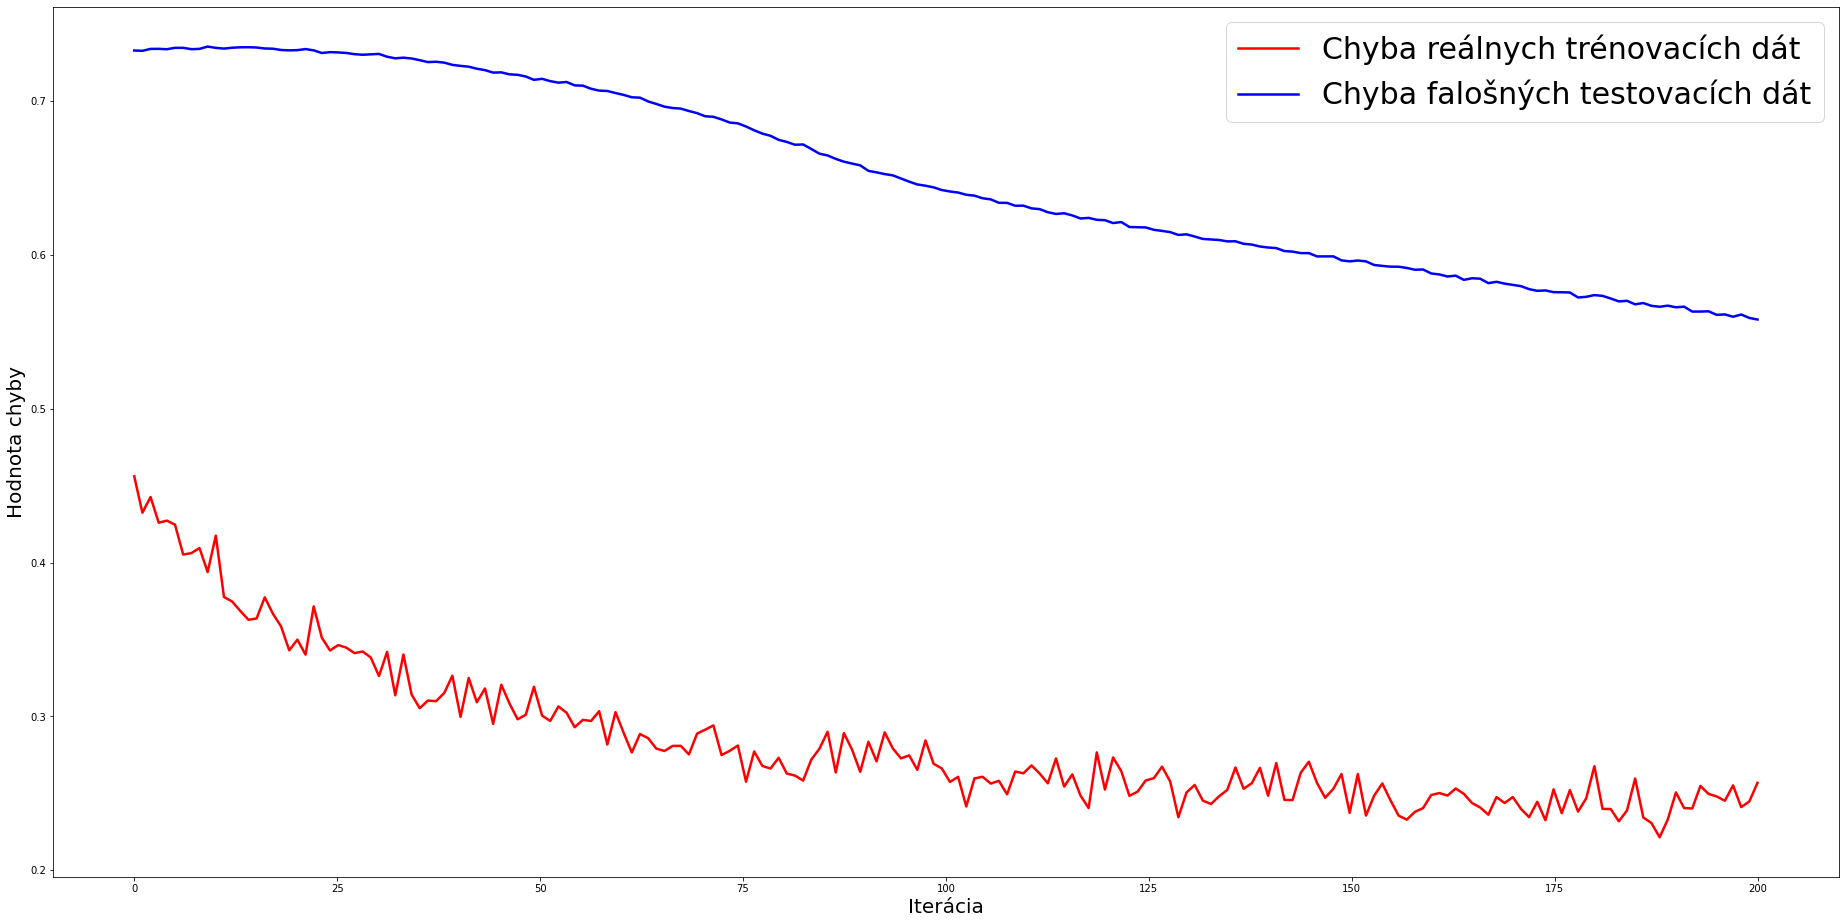

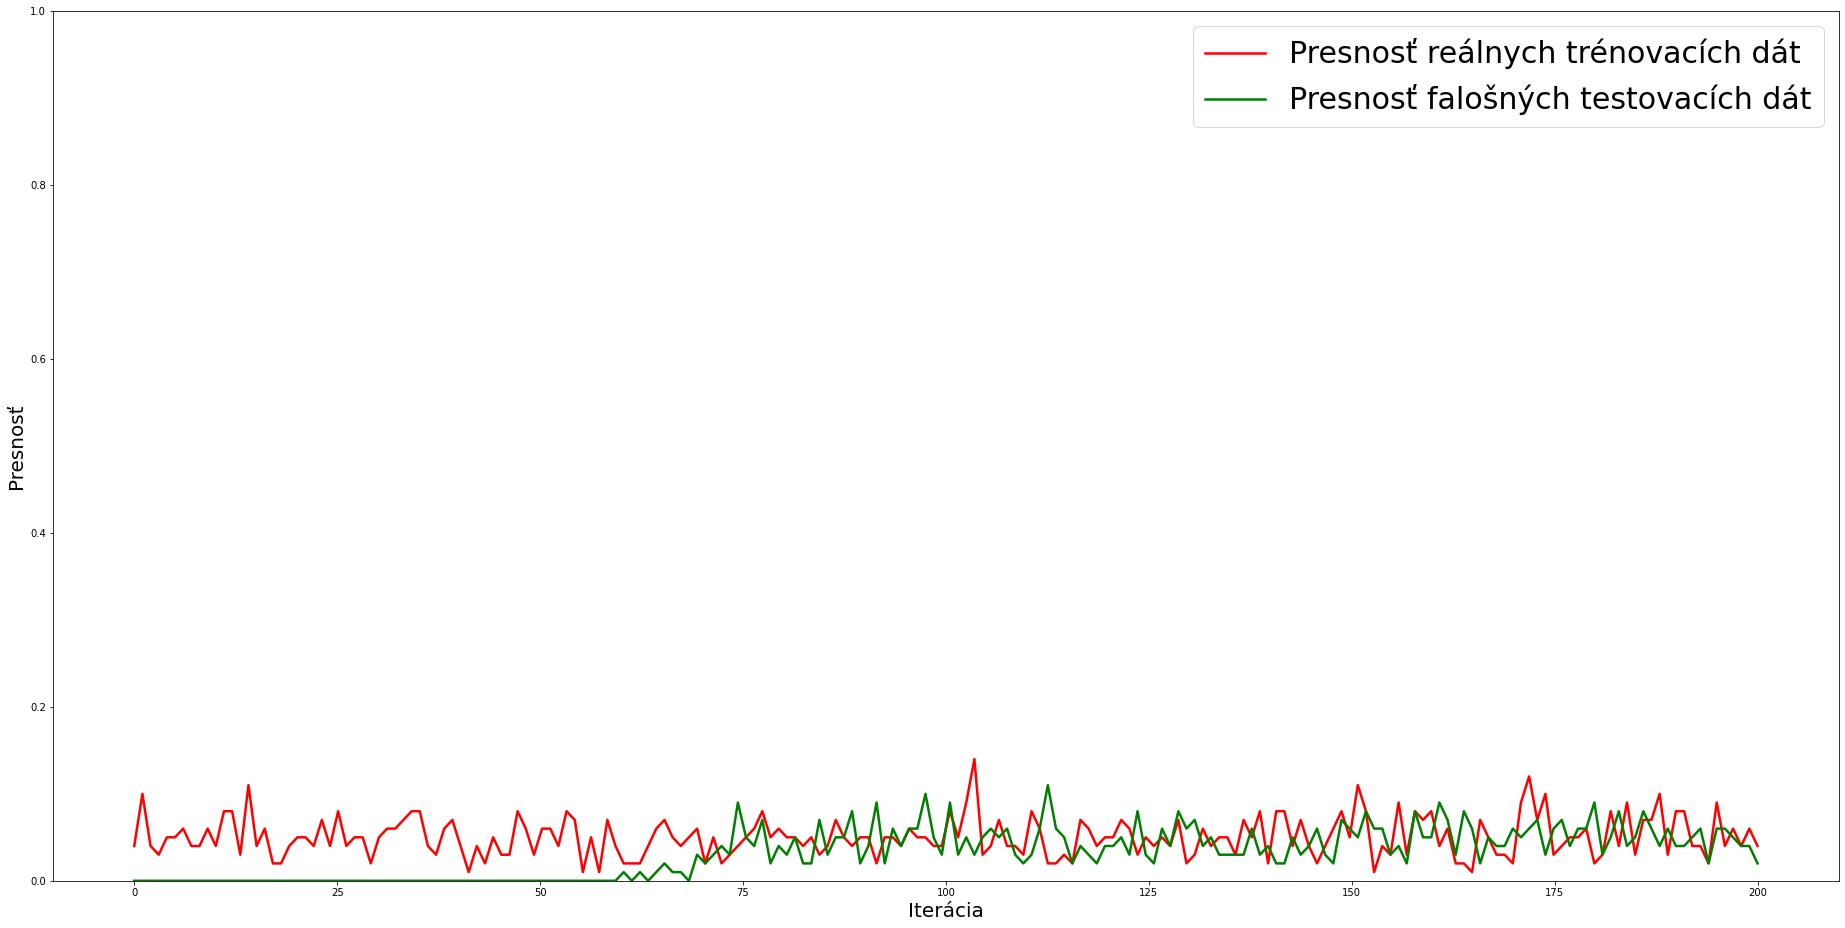

In [32]:
train_acc_graph=np.load(WORKDIR_PATH / "train_acc_graphA.npy")
fake_acc_graph=np.load(WORKDIR_PATH / "fake_acc_graphA.npy")

train_loss_graph=np.load(WORKDIR_PATH / "train_loss_graphA.npy")
loss_fake_graph=np.load(WORKDIR_PATH / "loss_fake_graphA.npy")

# filtered_acc_real2 = [ item for i,item in enumerate(d_real_acc_graph2) if i%100==0 ]
# filtered_acc_fake2 = [ item for i,item in enumerate(d_fake_acc_graph2) if i%100==0 ]

time_axis=np.linspace(0,200,200)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba reálnych trénovacích dát', 'x': time_axis, 'y': train_loss_graph[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba falošných testovacích dát', 'x': time_axis, 'y': loss_fake_graph[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Hodnota chyby',fontsize=20)
 
time_axis=np.linspace(0,200,200)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť reálnych trénovacích dát', 'x': time_axis, 'y': train_acc_graph[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť falošných testovacích dát', 'x': time_axis, 'y': fake_acc_graph[:], 'color':'g', 'linewidth':2.5}]
for signal in mysignals:
  #ax1 = fig.add_subplot(n, n, 1 + i)
  plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
  #ax1.axis('off')
  #ax1.axis('off')
  plt.legend(loc='upper right',prop={'size': 30})
  plt.xlabel('Iterácia',fontsize=20)
  plt.ylabel('Presnosť',fontsize=20)
  plt.ylim(0,1)

## Submodel for generator training

* Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space, generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

* To be clear, we are not talking about a new third model, just a logical third model that uses the already-defined layers and weights from the standalone generator and discriminator models.

* The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

* When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

* We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

Gan model summary :
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 3120, 1)           245701    
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 4316      
Total params: 250,017
Trainable params: 245,701
Non-trainable params: 4,316
_________________________________________________________________
Gan model plot: 


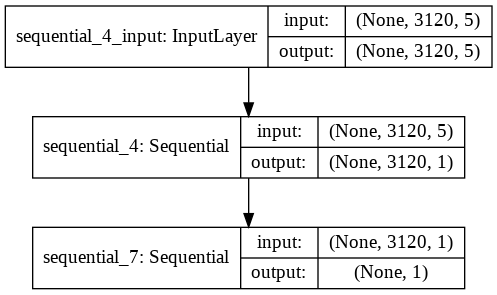

In [33]:
# submodel pre trenovanie generatoru

def define_gan(generator, discriminator):
	# zmrazenie vah diskriminatoru
	discriminator.trainable = False
	# prepojenie modelov
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# optimalizacny algoritmus generatoru
	#adam = Adam(lr=0.0002, beta_1=0.5)
	#sgd = SGD(lr=0.001) 
	sgd = SGD(lr=0.0001) 
	#sgd = SGD(lr=0.00001)
	model.compile(loss='binary_crossentropy', optimizer=sgd)
	return model

# vytvorenie submodelu
gan_model = define_gan(generator_model, discriminator_model)

# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

## Training GAN - complete model

### Notes from EKG paper:

*  Each model was trained for **500 epochs** with a **mini-batch size of 100**, where the length of the sequence comprised a series of ECG 3120 points and the learning rate was **1 × 10−5.** 

*  The dim for the noise data points was set to **5** and the **length of the generated ECGs was 400.** 

The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch. The generator loss is less critical and may hover between 0.5 and 2 or higher.

For example, I came across: Make the discriminator much less expressive by using a smaller model. Generation is a much harder task and requires more parameters, so the generator should be significantly bigger. [1]

In [0]:
# ukladanie priebehu ucenia GAN - grid signalov 5x5

def save_plot(acc_real, acc_fake, x_real,x_fake,length_of_signal,epoch, n=5):

  # vykreslenie signalov
  time_axis=np.linspace(0,length_of_signal/360,length_of_signal)
  fig = plt.figure(figsize=(32,16))
  fig.suptitle('Epoch :'+ "  " + str(epoch)+" | "+'acc_real ='+"  "+str(acc_real)+" | "+'acc_fake ='+"  "+str(acc_fake))
  for i in range(n * n):
    mysignals = [{'name': 'Real signal', 'x': time_axis, 'y': x_real[i], 'color':'r', 'linewidth':2.5},{'name': 'Fake signal', 'x': time_axis, 'y': x_fake[i], 'color':'b', 'linewidth':2.5}]
    for signal in mysignals:
      ax1 = fig.add_subplot(n, n, 1 + i)
      ax1.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])

  #ulozenie obrazku signalov na google disk
  plt.savefig(str(WORKDIR_PATH / "GAN/train6/epoch") + str(epoch))

# evaluacia modelu a ukladnie priebehu ucenia gan

def summarize_performance(epoch, g_model, d_model, SI2_II_11_test, latent_dim, batch_size, mu, sigma,length_of_signal):
	# evaluacia testovacich signalov
	x_real, y_real = generate_real_samples(batch_size,SI2_II_11_test)
	_, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
	# evaluacia falosnych vygenerovanych signalov
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, batch_size, mu, sigma)
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# vyhodnotenie 
	print('>Acc Test Real: %.0f%%, Acc Fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # ulozenie obrazkov priebehu ucenia GAN
	save_plot(acc_real, acc_fake, x_real,x_fake,length_of_signal,epoch, n=5)
	# ulozenie modelu generatoru
	g_model.save(str(WORKDIR_PATH / "GAN/train6/generatormodel") + str(epoch))
  

# trenovanie modelu GAN

def train(g_model, d_model, gan_model, latent_dim, signal_train, signal_test, mu, sigma,length_of_signal, n_epochs=100, batch_size=200, n_eval=2):
  #polovica velkosti skupiny a pocet iteracii jednej epochy
  batch_per_epoch = int( SI2_II_11.shape[1] / batch_size)
  half_batch = int(batch_size / 2)

  #epocha
  for i in range(n_epochs):
    # iteracia
    for j in range(batch_per_epoch):
      # vygenerovanie realnych signalov a trening diskriminatoru
      x_real,y_real = generate_real_samples(half_batch,signal_train)
      loss_real,acc_real = d_model.train_on_batch(x_real, y_real)
      # vygenerovanie falosnych signalov a trening diskriminatoru
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch, mu, sigma)
      loss_fake, acc_fake = d_model.train_on_batch(x_fake, y_fake)  
      # vygenerovanie latentnych bodov
      x_gan = generate_latent_points(latent_dim, batch_size,mu,sigma)
      # prevratenie oznacenia triedy falosnych signalov na realne
      y_gan = ones((batch_size, 1))
      # trening generatoru
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      # ulozenie presnosti a chyb modelov
      d_real_loss_graph_sgd3.append(loss_real)
      d_real_acc_graph_sgd3.append(acc_real)
      d_fake_loss_graph_sgd3.append(loss_fake)
      d_fake_acc_graph_sgd3.append(acc_fake)
      g_loss_graph_sgd3.append(g_loss)
      #ukladanie chyb na disk v pripade straty pripojenia/zlyhania
      np.save(WORKDIR_PATH / "d_real_loss_graph_sgd3",d_real_loss_graph_sgd3)
      np.save(WORKDIR_PATH / "d_real_acc_graph_sgd3",d_real_acc_graph_sgd3)
      np.save(WORKDIR_PATH / "d_fake_loss_graph_sgd3",d_fake_loss_graph_sgd3)
      np.save(WORKDIR_PATH / "d_fake_acc_graph_sgd3",d_fake_acc_graph_sgd3)
      np.save(WORKDIR_PATH / "g_loss_graph_sgd3",g_loss_graph_sgd3)
      # priebezne vysledky modelu
      print('>%d, %d/%d, d_real=%.0f%% d_fake=%.0f%%     		d_loss=%f  g_loss=%f' % (i+1,j+1,batch_per_epoch, acc_real*100, acc_fake*100, (loss_real+loss_fake), g_loss))
    # krok evaluacie modelu a ukladania priebehu ucenia GAN
    if (i+1) % n_eval == 0:
      summarize_performance(i+1, g_model, d_model, signal_test, latent_dim, batch_size, SI2_II_11_train_mean, SI2_II_11_train_std, length_of_signal)

# vytvorenie trenovacej a testovacej databazy 80/20 

number_of_train_signals=int(np.round(number_of_signals*0.8))
SI2_II_11_train=SI2_II_11[:,0:number_of_train_signals]
SI2_II_11_test=SI2_II_11[:,number_of_train_signals:number_of_signals]
print('Shape of TRAIN SI2 signals->     ' + str(np.shape(SI2_II_11_train)))
print('Shape of TEST SI2 signals ->     ' + str(np.shape(SI2_II_11_test)))

# statististiky signalov pre specificke rozlozenie latentnych bodov
SI2_II_11_train_mean=np.mean(np.mean(SI2_II_11_train, axis=0))
SI2_II_11_train_std=np.std(np.std(SI2_II_11_train, axis=0))
print('Mean of SI2_II_11_train_mean :')
print(SI2_II_11_train_mean)
print('Std of SI2_II_11_train_std :')
print(SI2_II_11_train_std)

d_real_loss_graph_sgd3=[]
d_real_acc_graph_sgd3=[]
d_fake_loss_graph_sgd3=[]
d_fake_acc_graph_sgd3=[]
g_loss_graph_sgd3=[]

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, SI2_II_11_train, SI2_II_11_test, SI2_II_11_train_mean, SI2_II_11_train_std, length_of_signal, n_epochs=100, batch_size=200, n_eval=2)



Shape of TRAIN SI2 signals->     (3120, 2636)
Shape of TEST SI2 signals ->     (3120, 659)
Mean of SI2_II_11_train_mean :
0.060996685
Std of SI2_II_11_train_std :
0.038492482


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, return_sequences=True, activation="tanh", kernel_initializer="glorot_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/16, d_real=6% d_fake=0%     		d_loss=1.025262  g_loss=0.590659
>1, 2/16, d_real=4% d_fake=0%     		d_loss=1.031134  g_loss=0.580122
>1, 3/16, d_real=7% d_fake=0%     		d_loss=1.032721  g_loss=0.566671
>1, 4/16, d_real=6% d_fake=0%     		d_loss=1.025137  g_loss=0.551924
>1, 5/16, d_real=2% d_fake=0%     		d_loss=1.002715  g_loss=0.535425
>1, 6/16, d_real=7% d_fake=0%     		d_loss=1.014398  g_loss=0.518424
>1, 7/16, d_real=3% d_fake=0%     		d_loss=1.015187  g_loss=0.500907
>1, 8/16, d_real=9% d_fake=0%     		d_loss=1.015909  g_loss=0.483438
>1, 9/16, d_real=6% d_fake=0%     		d_loss=1.029471  g_loss=0.464233
>1, 10/16, d_real=4% d_fake=0%     		d_loss=1.017399  g_loss=0.445067
>1, 11/16, d_real=4% d_fake=0%     		d_loss=1.009351  g_loss=0.426677
>1, 12/16, d_real=2% d_fake=0%     		d_loss=1.000210  g_loss=0.408689
>1, 13/16, d_real=3% d_fake=0%     		d_loss=1.002408  g_loss=0.391981
>1, 14/16, d_real=6% d_fake=0%     		d_loss=1.002486  g_loss=0.374449
>1, 15/16, d_real=1% d_fake=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently re

>3, 1/16, d_real=4% d_fake=3%     		d_loss=0.943398  g_loss=0.162306
>3, 2/16, d_real=5% d_fake=5%     		d_loss=0.962690  g_loss=0.156305
>3, 3/16, d_real=10% d_fake=5%     		d_loss=0.940558  g_loss=0.149694
>3, 4/16, d_real=3% d_fake=7%     		d_loss=0.956584  g_loss=0.144398
>3, 5/16, d_real=10% d_fake=7%     		d_loss=0.939027  g_loss=0.138242
>3, 6/16, d_real=4% d_fake=5%     		d_loss=0.949353  g_loss=0.133245
>3, 7/16, d_real=6% d_fake=6%     		d_loss=0.929405  g_loss=0.128430
>3, 8/16, d_real=3% d_fake=5%     		d_loss=0.943393  g_loss=0.122244
